# Training with contaminated levy data
This notebook contains the code to train the Convolutional Neural Network as demonstrated in _Learning the Likelihood: Using DeepInference for the Estimation of Diffusion-Model and Lévy Flight Parameters_.

Make sure to download the data into a folder named _reftab_. 

## Imports

In [1]:
import tensorflow as tf
from tensorflow import keras
import pandas as pd
# Helper libraries
import numpy as np
import matplotlib.pyplot as plt
import glob


print(tf.__version__)
np.random.seed(1223)

from sklearn.model_selection import train_test_split
from scipy import stats
from subprocess import run, check_output
import os
import random
import matplotlib.pyplot as plt
import time

/home/ulf/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


1.9.0


In [2]:
paramnames = ['a','zr','v1','v2','t0','szr','sv','st0','alpha']
alpha_constant = False
contaminated = False
trainingpath ='data/levy/contaminated/'
testpath = 'data/levy/'
filenames = glob.glob(trainingpath+'*.csv')
print(filenames)

['data/levy/contaminated/levy_ref_100_3.csv', 'data/levy/contaminated/levy_ref_100_1.csv', 'data/levy/contaminated/levy_ref_100_5.csv', 'data/levy/contaminated/levy_ref_100_2.csv', 'data/levy/contaminated/levy_ref_100_4.csv']


## Import and preprocessing

In [3]:
def preprocess_data(filenames, 
                    nparams=11, 
                    header=None, 
                    sep=';', 
                    ncond=2,
                    alpha_constant=True,
                    contaminated=True):
    """
    Import data and preprocess.
    """
    dataframes = []
    for filename in filenames:
        dataframe = pd.read_csv(filename,header=header, sep=sep)
        dataframes.append(dataframe.values)
    
    data = np.vstack(dataframes)
    y_train = data[:,:nparams]
    
    if alpha_constant:
        if contaminated:
            y_train = np.delete(y_train, 8, axis=1)
        else:
            y_train = np.delete(y_train,[8,9,10],axis=1)
    else:
        if not contaminated:
            y_train = np.delete(y_train, [9,10], axis=1)

    
    X_train = data[:,nparams:]
    X_train = X_train.reshape(X_train.shape[0],X_train.shape[1]//ncond,ncond)
    
    return X_train, y_train

In [4]:
X_train, y_train = preprocess_data(filenames,
                                   alpha_constant=alpha_constant,
                                   contaminated=contaminated)

## Test data

### Clean within prior

In [5]:
X_test_clean_within, y_test_clean_within = preprocess_data([f'{testpath}levy_test_0.csv'],
                                   alpha_constant=False,
                                   contaminated=False)

### Clean out of prior

In [6]:
X_test_clean_out, y_test_clean_out = preprocess_data([f'{testpath}levy_test_sl_0.csv'],
                                   alpha_constant=False,
                                   contaminated=False)

### Contaminated within prior

In [7]:
X_test_contamin_within, y_test_contamin_within = preprocess_data([f'{testpath}levy_test_100.csv'],
                                   alpha_constant=False,
                                   contaminated=False)

### Contaminated out of prior

In [8]:
X_test_contamin_out, y_test_contamin_out = preprocess_data([f'{testpath}levy_test_sl_100.csv'],
                                   alpha_constant=False,
                                   contaminated=False)

## Hyperparameters

In [9]:
# set the path:
PATH = os.getcwd()

os.makedirs(os.path.join(PATH,'img'),exist_ok=True)

# how deep should the model be:
filters = [64,64,128,128,128]

# number of channels:
nchannels = 2

# optimizer:
optimizer = 'adam'

# Batch size:
batchsize = 64

checkpoint_path = "model_checkpoints/levy/trained_model_contamin.hdf5"

## Heteroscedastic loss function

In [10]:
def heteroscedastic_loss(true, pred):
    """ Heteroskedastic loss function."""
    params = pred.shape[1]//2
    point = pred[:, :params]
    var = pred[:, params:]
    precision = 1 / var
    return keras.backend.sum(precision * (true - point) ** 2. + keras.backend.log(var), -1)

## Plot function

In [11]:
def plot_analytic_vs_est(true, pred, names ,log=True, plot_abline=True,show=True,filename='figure.png',path=None):
    """Create a 3x2 plot as in paper."""
    
    def abline(slope, intercept, ax):
        x = np.array(ax.get_xlim())
        y = intercept + slope * x
        return x, y 
    
    font = {'fontname':'Arial', 'fontsize': 16}
    textfont = {'fontname':'Arial', 'fontsize': 11}
    axisfont = {'fontname':'Arial', 'fontsize': 12}
    

    f, axarr = plt.subplots(2, 5, figsize=(15, 10))
    
    
    for i, ax in enumerate(axarr.flat):
        
       
        if i == (pred.shape[1]//2):
            print(i)
            break
        #Yerr = np.sqrt(pred[:,i+len(names)])
        #overall_uncertainty = np.round(np.mean(Yerr/true[:,i],axis=0),2)
        #ax.errorbar(true[:,i], pred[:,i],yerr=Yerr,fmt='o',color='black',linewidth=0.3,alpha=0.2)
        ax.plot(true[:,i], pred[:,i],marker='o', linewidth=0,alpha=0.1,color='black')
        #ax.plot(true[:,i], pred[:,i] + np.sqrt(pred[:,i+8]),color='red')
        #ax.plot(true[:,i], pred[:,i] - np.sqrt(pred[:,i+8]),color='green')
        cor = np.round(np.corrcoef(true[:,i],pred[:,i])[0,1],2)
        r_squared = np.round(1 -(np.var(true[:,i] - pred[:,i])/np.var(true[:,i])),2)
       
        ax.text(0.2,0.9,'r: ' + str(cor),ha='center', va='center', transform=ax.transAxes,**textfont)
        ax.text(0.2,0.8,'R2: ' + str(r_squared),ha='center', va='center', transform=ax.transAxes,**textfont)
        
        if plot_abline:
            ax.plot(*abline(1, 0, ax),color='black')
        else:
            ax.plot(*best_line_fit(true[:,i], pred[:,i]))
        if i == 0:
            ax.set_xlabel('True',**axisfont)
            ax.set_ylabel('Estimated',**axisfont)
            
        ax.set_title(names[i],**font)
        
        ax.yaxis.set_ticks_position('left')
        ax.xaxis.set_ticks_position('bottom')
        
        #ax.spines['right'].set_visible(False)
        #ax.spines['top'].set_visible(False)
     
    f.savefig(os.path.join(path,filename))
    f.subplots_adjust(hspace=.3)
    if show:
        plt.show()
    return None

## The model architecture

In [12]:
def create_model(n_params, channels, filters, batchnorm = False, training = True):
    """Creates 1DConv model."""
    
    inp = keras.Input(shape=(None, channels))
    x = inp
    x = keras.layers.Conv1D(filters[0], kernel_size=1, strides=1, activation='relu')(x)
    
    for f in filters[1:]:
        x = keras.layers.Conv1D(f, kernel_size=3, strides=2, activation='relu')(x)
        #x = keras.layers.Dropout(rate=0.2)(x,training=True)
        if batchnorm:
            x = keras.layers.BatchNormalization()(x,training=training)
    
    x = keras.layers.GlobalAveragePooling1D()(x)
    mean = keras.layers.Dense(n_params)(x)
    var = keras.layers.Dense(n_params, activation='softplus')(x)
    out = keras.layers.Concatenate()([mean, var])
    model = keras.Model(inp, out)
    return model

## Training

In [13]:
keras.backend.clear_session()
deepInference = create_model(n_params=len(paramnames),channels=nchannels,filters=filters)
#deepInference.summary()

In [14]:
deepInference.compile(optimizer=optimizer, loss=heteroscedastic_loss)
earlystopper = keras.callbacks.EarlyStopping(monitor='val_loss', patience=2, verbose=1)
checkpointer = keras.callbacks.ModelCheckpoint(checkpoint_path,save_best_only=True,verbose=1)

In [15]:
%%time
history = deepInference.fit(X_train, 
                            y_train, 
                            batch_size=batchsize,
                            epochs=10, 
                            validation_split=0.01,
                            callbacks=[earlystopper, checkpointer])

Train on 495000 samples, validate on 5000 samples
Epoch 1/10
495000/495000 [==============================] - 125s 253us/step - loss: -16.7571 - val_loss: -19.4065

Epoch 00001: val_loss improved from inf to -19.40655, saving model to model_checkpoints/levy/trained_model_contamin.hdf5
Epoch 2/10
495000/495000 [==============================] - 124s 250us/step - loss: -20.0121 - val_loss: -20.0360

Epoch 00002: val_loss improved from -19.40655 to -20.03604, saving model to model_checkpoints/levy/trained_model_contamin.hdf5
Epoch 3/10
495000/495000 [==============================] - 124s 250us/step - loss: -20.8065 - val_loss: -20.7904

Epoch 00003: val_loss improved from -20.03604 to -20.79036, saving model to model_checkpoints/levy/trained_model_contamin.hdf5
Epoch 4/10
495000/495000 [==============================] - 123s 249us/step - loss: -21.2755 - val_loss: -21.3009

Epoch 00004: val_loss improved from -20.79036 to -21.30094, saving model to model_checkpoints/levy/trained_model_co

## Validation

In [16]:
pred_within = deepInference.predict(X_test_contamin_within)
pred_out= deepInference.predict(X_test_contamin_out)

9


/home/ulf/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1316: UserWarning: findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


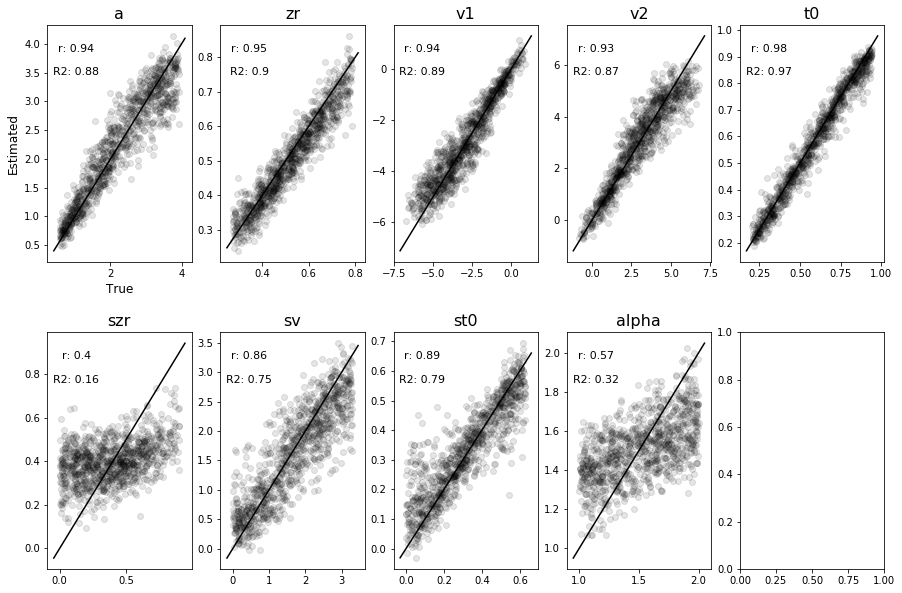

In [17]:
plot_analytic_vs_est(y_test_contamin_within,
                     pred_within,
                     log=False,
                     names=paramnames,
                     path=PATH,
                     show=True,filename='img/contamin_within_levy.png')

9


/home/ulf/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1316: UserWarning: findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


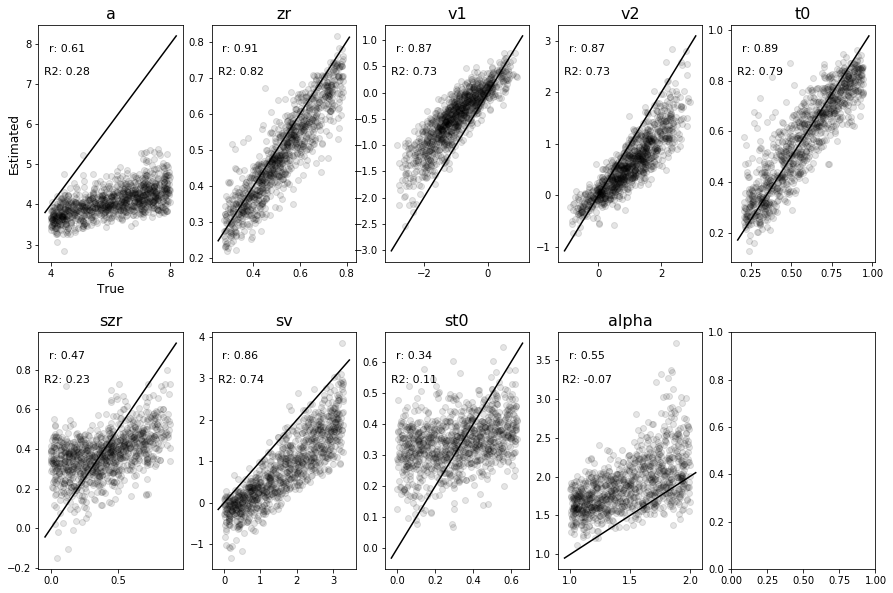

In [18]:
plot_analytic_vs_est(y_test_contamin_out,
                     pred_out,
                     log=False,
                     names=paramnames,
                     path=PATH,
                     show=True,filename='img/contamin_out_levy.png')